# <center> Lecture12 : normal & Negative Binomial Regression </center>  
 
## <center> Instructor: Dr. Hu Chuan-Peng </center> 

## Intro

* 在之前的课程中，我们探索了自我控制的影响因素，我们将自我控制分数作为连续变量来处理

* 在真实的数据处理中，因变量的类型并不仅限于连续数据(continuous data)，可能我们关心被试是否做出正确回答(binary data)，或是给出正确回答的个数(count data)

* 目前，我们只介绍了正态回归模型，但它并非适用于所有数据类型

* 在本节课中，我们关注如何对**计数数据**进行分析


**数据集介绍**

* 使用的数据集仍然来自来自Human Penguin Project (Hu et al., 2018, doi: 10.17605/OSF.IO/H52D3)，本节课中我们关注**压力**与**社交网络大小**之间的关系。

* 在这份数据中，社交网络大小的定义为，在每两周内，个体的社交对象数量(社交对象包含父母、子女、同事等等)


> * 数据来源: Hu, C.-P. et al. (2018). Raw data from the Human Penguin Project. Open Science Framework. https://doi.org/10.17605/OSF.IO/H52D3  
> * 压力量表来源：Cohen, S., Kamarck, T. & Mermelstein, R. A global measure of perceived stress. J. Health. Soc. Behav. 24, 385–396 (1983).  
> * 社交网络测量：Cohen, S. et al. Social ties and susceptibility to the common cold. JAMA 277, 1940–1944 (1997).

**原始数据可视化**

* 社交网络大小的分布情况

* 压力与社交网络大小的散点图情况(在本节课中，我们将个体的恋爱情况也作为自变量之一)

![Image Name](https://cdn.kesci.com/upload/s4o8026lgp.png?imageView2/0/w/960/h/960)

In [108]:
# 导入 pymc 模型包，和 arviz 等分析工具 
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

# 忽略不必要的警告
import warnings
warnings.filterwarnings("ignore")

In [109]:
# 通过 pd.read_csv 加载数据 Data_Sum_HPP_Multi_Site_Share.csv
df_raw = pd.read_csv('Data_Sum_HPP_Multi_Site_Share.csv')

df = df_raw[df_raw["Site"] == "Tsinghua"]

#1 = "yes"; 2 = "no"
df["romantic"] =  np.where(df['romantic'] == 2, 0, 1)
df["romantic_recode"] =  np.where(df['romantic'] == 1, "yes", "no")

#设置索引
df["index"] = range(len(df))
df = df.set_index("index")

**Normal regression model**

* 此时如果我们忽略了因变量为计数变量，仍然使用正态回归模型进行分析

$$  
 
\begin{array}{lcrl}  

\text{data:} & \hspace{.05in} & Y_i|\beta_0,\beta_1,\beta_2,\sigma & \stackrel{ind}{\sim} N(\mu_i, \; \sigma^2)  \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1X_{i1} + \beta_2X_{i2} \\  
\text{priors:} & & \beta_{0}  & \sim N\left(20, 10^2 \right)  \\  
                    & & \beta_1  & \sim N\left(0, 10^2 \right) \\  
                    & & \beta_2  & \sim N\left(0, 10^2 \right) \\  
                    & & \sigma   & \sim \text{Exp}(0.6)  .\\  
\end{array}  

$$  

* 我们快速运行模型定义、MCMC采样和后验预测分布的结果

In [110]:
with pm.Model(coords = {"obs_id": df.index}) as normal_model:

    beta_0 = pm.Normal("beta_0", mu=20, sigma=10)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)           #定义beta_1
    beta_2 = pm.Normal("beta_2", mu=0, sigma=10)           #定义beta_2
    sigma = pm.Exponential("sigma", 0.6)                   #定义sigma

    stress = pm.MutableData("stress",df.stress, dims="obs_id")                           #自变量1:压力水平
    romantic = pm.MutableData("romantic",df.romantic, dims="obs_id")                              #自变量2:性别
    mu = pm.Deterministic("mu", beta_0 + beta_1*stress + beta_2*romantic, dims="obs_id")    #定义mu，自变量与先验结合

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df.networksize, dims="obs_id") 

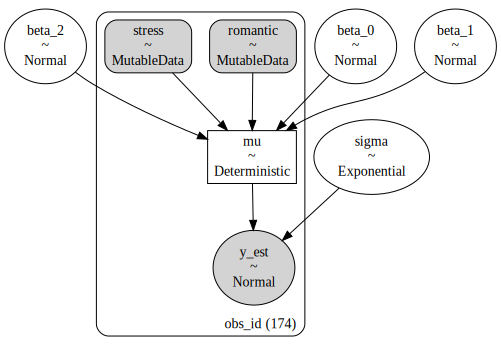

In [111]:
pm.model_to_graphviz(normal_model)

In [112]:
#===========================
#     注意！！！以下代码可能需要运行1-2分钟左右
#===========================
with normal_model:
    normal_model_trace = pm.sample(draws=5000,            # 使用mcmc方法进行采样，draws为采样次数
                      tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                      chains=4,                     # 链数
                      discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                      random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 131 seconds.


In [113]:
with normal_model:
    normal_model_ppc = pm.sample_posterior_predictive(normal_model_trace, random_seed=84735) 

Sampling: [y_est]


In [114]:
# 定义计算 MAE 函数
from statistics import median
def MAE(model_ppc):
    # 计算每个X取值下对应的后验预测模型的均值
    pre_y = model_ppc.posterior_predictive["y_est"].stack(sample=("chain", "draw"))
    pre_y_mean = pre_y.mean(axis=1).values

    # 提取观测值Y，提取对应Y值下的后验预测模型的均值
    MAE = pd.DataFrame({
        "networksize_ppc_mean": pre_y_mean,
        "networksize_original": df.networksize
    })

    # 计算预测误差
    MAE["pre_error"] = abs(MAE["networksize_original"] -\
                            MAE["networksize_ppc_mean"])

    # 最后，计算预测误差的中位数
    MAE = median(MAE.pre_error)
    return MAE

In [115]:
# 定义计算超出HDI的数量
def counter_outlier(model_ppc, hdi_prob=0.95):
    # 将az.summary生成的结果存到hdi_multi这个变量中，该变量为数据框
    hdi = az.summary(model_ppc, kind="stats", hdi_prob=hdi_prob)
    lower = hdi.iloc[:,2].values
    upper = hdi.iloc[:,3].values

    # 将原数据中的自我控制分数合并，便于后续进行判断
    y_obs = model_ppc.observed_data["y_est"].values

    # 判断原数据中的压力分数是否在后验预测的95%可信区间内，并计数
    hdi["verify"] = (y_obs <= lower) | (y_obs >= upper)
    hdi["y_obs"] = y_obs
    hdi_num = sum(hdi["verify"])

    return hdi_num

In [116]:
normal_model_MAE = MAE(normal_model_ppc)
print(f"正态回归模型MAE: {normal_model_MAE:.2f}")

normal_model_outliers = counter_outlier(normal_model_ppc)
print(f"泊松回归模型超出95%hdi: {normal_model_outliers:.2f}")

正态回归模型MAE: 5.86
泊松回归模型超出95%hdi: 8.00


<Axes: xlabel='y_est / y_est'>

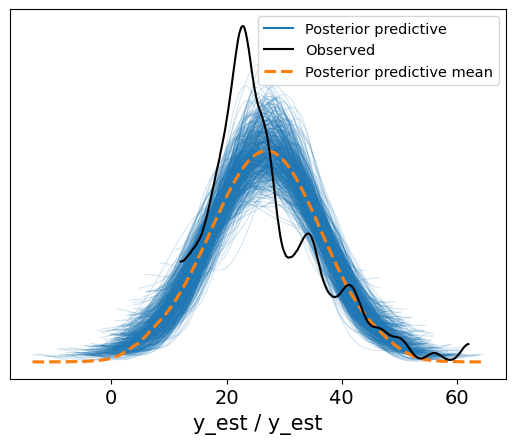

In [117]:
az.plot_ppc(normal_model_ppc, num_pp_samples=500)

## Poisson regression

> 在lec5中，我们曾介绍过泊松分布，当时使用的例子为在亚运会时，中国每天获得的金牌数量。

* **泊松分布(Poisson distribution)** 表示在给定$\lambda$下，用来描述时间在一定的时间或空间内发生的事件个数，$\lambda$为事件的平均发生率或事件发生的均值

![Image Name](https://cdn.kesci.com/upload/s4o80dsjlv.png?imageView2/0/w/960/h/960)

* 在正态回归模型中，对数据的假设为 $$ Y_i|\beta_0,\beta_1,\beta_2,\sigma  \stackrel{ind}{\sim} N(\mu_i, \; \sigma^2)  \;\; \text{ with } \;\; \lambda_i = \beta_0 + \beta_1X_{i1} + \beta_2X_{i2} \\ $$

    > 即因变量的均值可以表示为自变量的线性组合，且因变量符合以该均值为中心的正态分布


* 类似的，我们也可以在泊松回归模型中做出这样的假设：
$$Y_i | \lambda_i \stackrel{ind}{\sim} Pois\left(\lambda_i \right) \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1X_{i1} + \beta_2X_{i2} （1） \\$$

* 需要注意的是，在公式(1)中，事件的发生率 $\lambda_i$ 就会出现负数，这显然是不合理的

### 泊松回归模型公式

* 我们可以对$\lambda_i $进行对数转换

    * $log(\lambda_i)$既可以是正数也可以是负数
$$\log\left( \lambda_i \right) = \beta_0 + \beta_1 X_{i1}+ \beta_2 X_{i2} $$

* 此时，泊松回归模型应该写成：

$$
Y_i | \beta_0,\beta_1, \beta_2 \stackrel{ind}{\sim} Pois\left(\lambda_i\right) \;\; \text{ with } \;\; \lambda_i = e^{\beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2}}
$$

### 各参数的解释

> 为方便演示，下图中只介绍包含一个自变量$X_1$的情况

如下图所示，在给定的$x$下，观测值$Y$满足 $ Pois(\lambda_i)$，且 $\lambda_i = e^{\beta_0 + \beta_1 X_{i1}}$

![Image Name](https://bookdown.org/roback/bookdown-BeyondMLR/bookdown-BeyondMLR_files/figure-html/OLSpois-1.png)


**公式中各参数的意义：**  

* $\beta_0$  

    * 当$X_1= 0$时，$\lambda_i = e^{\beta_0}$，当自变量都为0时，事件的平均发生率

* $\beta_1$ 

    * 假设 $X_1= 1$，$X_2= 2$，$\lambda_1 =e^{\beta_0 + \beta_1}$，$\lambda_2 =e^{\beta_0 + 2\beta_1}$

    * $\beta_1 = log(\lambda_2) - log(\lambda_1)$，$e^{\beta_1} = \frac{\lambda_2}{\lambda_1}$ 

    * $ e^{\beta_1} = \frac{\lambda_{x+1}}{\lambda_x} $
    
    > 在其他自变量不变的情况下，自变量$X_1$每增加一个单位，事件的平均发生率$\lambda_i$就会以$e^{\beta_1}$倍增长


### 泊松回归的预设

1. **计数数据：** 适用于因变量是计数数据的情况，即非负整数，例如事件发生的次数、计数的数量等。

2. **独立性：** 假设每个观测值$Y_i$是相互独立的，即一个观测值不受其他观测值的影响。

4. **线性关系：** 经对数转换后的因变量 可以写作自变量的线性组合，如：$$\log\left( \lambda_i \right) = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2}+ \beta_3 X_{i3}$$

3. **均值等于方差：** 对于泊松分布$Pois(\lambda_i)$来说，其均值和方差都与事件的发生率相等(或约等)，$E(Y) = \text{Var}(Y) = \lambda$。

    * 需要注意的是，这并不意味着因变量本身的分布是泊松分布。在泊松回归中，我们说的是，在给定的X下，其观测到的Y需要满足泊松分布

    * 若此假设被满足，在数据中我们可以看到，因变量均值增大的同时，其变异性也在增大

    * 该假设是泊松回归的一个重要假设，当均值远大于方差时，泊松回归可能并不是最佳的模型选择，之后我们会介绍这种情况下更适合的模型选择。
    
<table>  
	  <tr>  
			<td><img src="https://cdn.kesci.com/upload/s4nzvo4egp.png?imageView2/0/w/960/h/960" alt="" width="50" height="200"> </td>  
			<td><img src="https://www.bayesrulesbook.com/bookdown_files/figure-html/ch-12-pois-assumptions-1.png" alt="" width="100" height="200"> </td>  
   </tr>  
</table>  

### 模型定义

\begin{equation}
\begin{array}{lcrl} 
\text{data:} & \hspace{.025in} & Y_i|\beta_0,\beta_1,\beta_2 & \stackrel{ind}{\sim} Pois\left(\lambda_i \right) \;\; \text{ with } \;\;
\lambda_i = e^{\beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2}}\\
\text{priors:} & & \beta_{0c} & \sim N\left(0, 0.5^2 \right) \\
&& \beta_1 & \sim N(0, 0.1^2) \\
&& \beta_2 & \sim N(0, 0.5^2) \\
\end{array}
\end{equation}

In [118]:
with pm.Model(coords = {"obs_id": df.index})  as poisson_model:

    beta_0 = pm.Normal("beta_0", mu=0, sigma=0.5)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.1)           #定义beta_1
    beta_2 = pm.Normal("beta_2", mu=0, sigma=0.5)           #定义beta_2

    stress = pm.MutableData("stress",df.stress, dims="obs_id")                           #自变量1:压力水平
    romantic = pm.MutableData("romantic",df.romantic, dims="obs_id")                              #自变量2:性别
    lam = pm.Deterministic("lam", 
                           pm.math.exp(beta_0 + beta_1*stress + beta_2*romantic), 
                           dims="obs_id")    #定义mu，自变量与先验结合

    likelihood = pm.Poisson("y_est", mu=lam, observed=df.networksize, dims="obs_id") 

#### 先验预测检验

* 前面说到使用正态回归模型会导致事件的发生率$\lambda_i$为负数，我们可以使用`pm.sample_prior_predictive`进行先验预测检验，来查看生成的$\lambda_i$情况

In [119]:
poisson_prior =pm.sample_prior_predictive(samples=50, 
                                          model=poisson_model,
                                          var_names=["lam"],
                                          random_seed=84735)

Sampling: [beta_0, beta_1, beta_2]


In [120]:
normal_prior =pm.sample_prior_predictive(samples=50, 
                                          model=normal_model,
                                          var_names=["mu"],
                                          random_seed=84735)

Sampling: [beta_0, beta_1, beta_2]


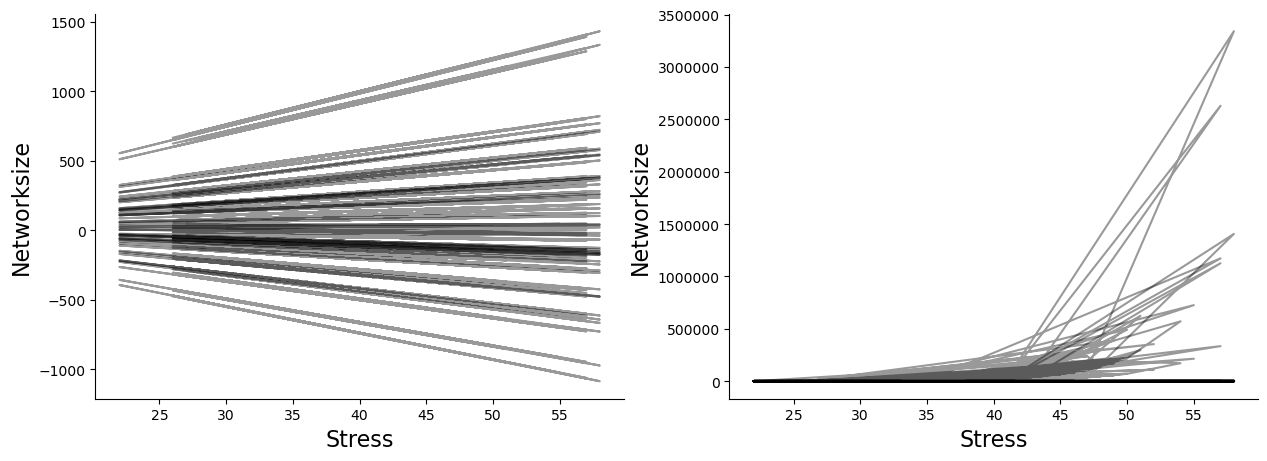

In [121]:
fig, ax = plt.subplots(1,2,figsize=(15, 5))

#绘制正态回归模型中，预测变量为压力情况下的先验预测线性模型
ax[0].plot(normal_prior.constant_data["stress"], 
           normal_prior.prior["mu"].stack(sample=("chain", "draw")), c="k", alpha=0.4)

#设置坐标轴标题
ax[0].set_xlabel('Stress', fontsize=16) 
ax[0].set_ylabel('Networksize', fontsize=16) 

#绘制绘制泊松回归模型中，预测变量为压力情况下的先验预测线性模型
ax[1].plot(poisson_prior.constant_data["stress"], 
           poisson_prior.prior["lam"].stack(sample=("chain", "draw")), c="k", alpha=0.4)

#设置坐标轴标题、y轴刻度显示
ax[1].set_xlabel('Stress', fontsize=16) 
ax[1].set_ylabel('Networksize', fontsize=16) 
ax[1].ticklabel_format(axis='y', style='plain')

sns.despine()
plt.show()


#### 绘制模型图

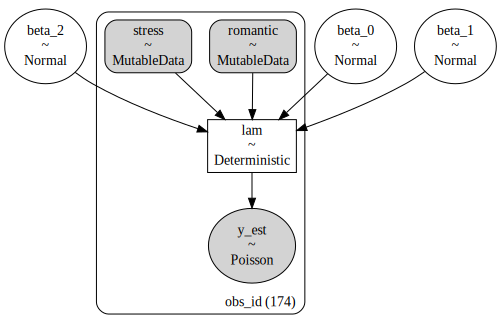

In [122]:
pm.model_to_graphviz(poisson_model)

### MCMC采样

In [123]:
#===========================
#     注意！！！以下代码可能需要运行1-2分钟左右
#===========================
with poisson_model:
    poisson_model_trace = pm.sample(draws=5000,            # 使用mcmc方法进行采样，draws为采样次数
                      tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                      chains=4,                     # 链数
                      discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                      random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 124 seconds.


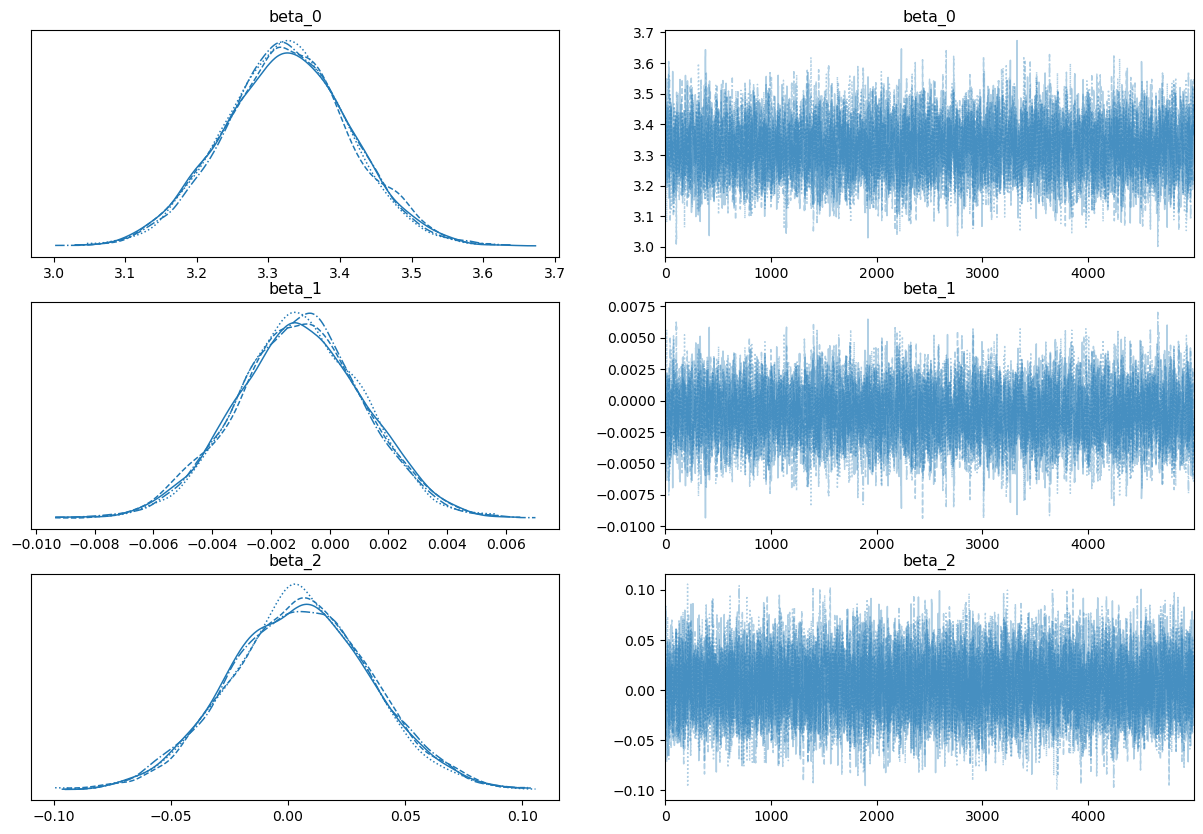

In [124]:
az.plot_trace(poisson_model_trace, var_names=["beta_0","beta_1","beta_2"],
              figsize=(15,10))
plt.show()


### 后验预测回归模型

In [125]:
with poisson_model:
    poisson_model_ppc = pm.sample_posterior_predictive(poisson_model_trace, random_seed=84735) 

Sampling: [y_est]


In [126]:
# 分别获取romantic=0及romantic=1时，压力变量对应的索引值
single_index = xr.DataArray(df.query("romantic == 0")["stress"])["index"].values
romantic_index = xr.DataArray(df.query("romantic == 1")["stress"])["index"].values

In [127]:
# 根据上一步获得的索引值，将参数的后验预测分布分成两部分
# 一部分为吸烟情况下，参数的后验预测分布、压力分数、自我控制分数
# 另一部分为不吸烟情况下，参数的后验预测分布、压力分数、自我控制分数
single_para = poisson_model_trace.sel(obs_id=single_index)
romantic_para = poisson_model_trace.sel(obs_id=romantic_index)

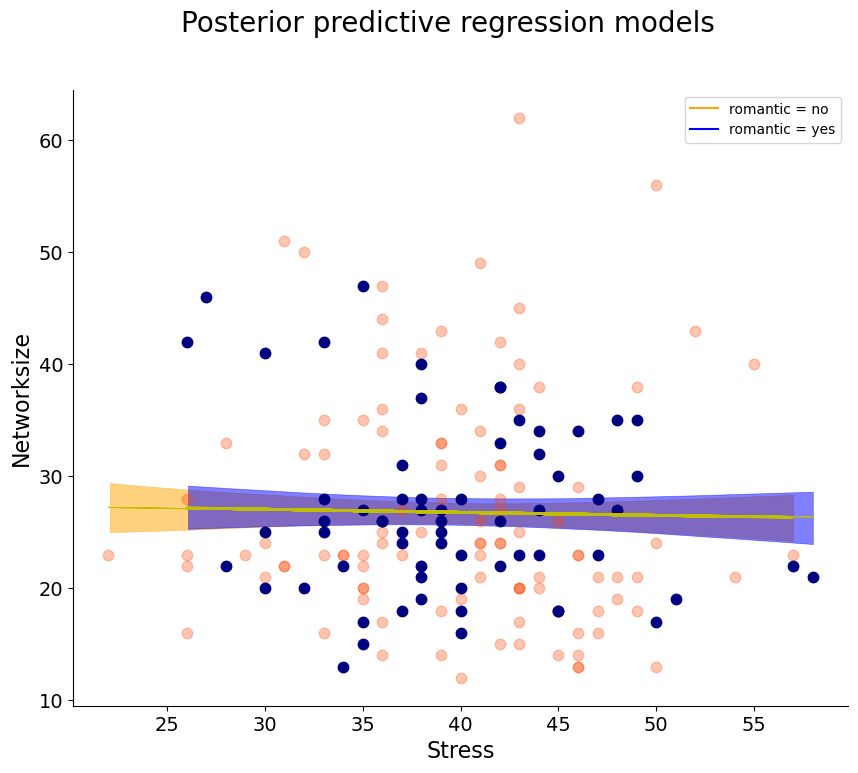

In [128]:
fig, axes = plt.subplots(figsize=(10, 8))

#绘制smoke=0情况下的后验预测线性模型
az.plot_lm(idata=single_para,
        y= "y_est",
        x= "stress",
        y_model = single_para.posterior["lam"],
        kind_model = "hdi",
        textsize=15,
        grid=False,
        axes=axes,
        legend=False,
        y_model_fill_kwargs = {"color":"orange"},         # 设置 hdi 区间颜色
        y_kwargs =  {"color":"orangered","alpha":0.3}     # 设置观测值颜色
        )

#----------------------------------------#
#绘制smoke=1情况下的后验预测线性模型
az.plot_lm(idata=romantic_para,
        y= "y_est",
        x= "stress",
        y_model = romantic_para.posterior["lam"],
        kind_model = "hdi",
        textsize=15,
        grid=False,
        axes=axes,
        y_model_fill_kwargs = {"color":"blue"},         # 设置 hdi 区间颜色
        y_kwargs =  {"color":"navy"},                   # 设置观测值颜色
        legend=False)

#设置坐标轴标题
axes.set_xlabel('Stress', fontsize=16) 
axes.set_ylabel('Networksize', fontsize=16) 

#设置图例
handles = [
        plt.Line2D([], [], color="orange",
                    label = 'romantic = no'),
        plt.Line2D([], [], color="blue",
                    label = 'romantic = yes')]

axes.legend(handles=handles)
#----------------------------------------#
# 设置坐标轴字体大小、总标题
axes.tick_params(labelsize=14)  
fig.suptitle('Posterior predictive regression models', fontsize=20)
sns.despine()

### 后验预测分布

<Axes: xlabel='y_est / y_est'>

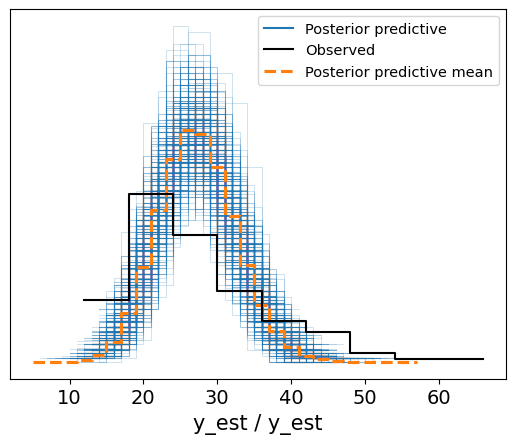

In [129]:
az.plot_ppc(poisson_model_ppc, num_pp_samples=500)

### 评估后验预测

In [130]:
# 输出结果
poisson_model_MAE = MAE(poisson_model_ppc)
print(f"泊松回归模型MAE: {poisson_model_MAE:.2f}")

# 输出结果
poisson_model_outliers = counter_outlier(poisson_model_ppc)
print(f"泊松回归模型超出95%hdi: {poisson_model_outliers:.2f}")


泊松回归模型MAE: 5.91


泊松回归模型超出95%hdi: 46.00


### 模型比较

In [131]:
with normal_model:
    pm.compute_log_likelihood(normal_model_trace)

with poisson_model:
   pm.compute_log_likelihood(poisson_model_trace)


In [132]:
comparison_list = {
    "model1(normal)":normal_model_trace,
    "model2(poisson)":poisson_model_trace,
}
az.compare(comparison_list)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model1(normal),0,-637.875179,4.337762,0.000000,0.893892,11.968966,0.000000,False,log
model2(poisson),1,-709.111664,9.236234,71.236485,0.106108,30.371556,18.617575,False,log


🤔 **为什么泊松回归模型的表现反而变差了?**

* 在泊松回归中，一个重要的假设是**均值与方差相等**，但实际上，我们的数据并不满足这个假设

* 我们可以将根据恋爱状况和压力将数据进行分组，将每个组内的均值与方差进行比较

![Image Name](https://cdn.kesci.com/upload/s4ok20dfbr.png?imageView2/0/w/960/h/960)

In [145]:
#这里就是大概分个组
#此数据中，压力的范围为20-60，可以每隔5个取为一组，如20-25为第一组，25-30为第二组
stress_bins = range(20,60,5)

#设定分组名称
stress_labels = [f'stress_group{i}' for i in range(1,len(stress_bins))]

#使用pd.cut，根据压力分数生成新的一列，为压力组别
df["stress_group"] = pd.cut(df["stress"], 
                            bins=stress_bins, 
                            labels=stress_labels)

#根据恋爱情况、压力组对社交网络大小进行分组，并计算每个组内的均值与方差
df.groupby(['romantic_recode','stress_group'])['networksize'].agg(['mean','var'])
#(注：NaN是由于分组中缺乏数据)

mean         var
romantic_recode stress_group                        
no              stress_group1  23.000000         NaN
                stress_group2  23.750000   25.071429
                stress_group3  27.529412  106.264706
                stress_group4  28.370370   94.396011
                stress_group5  27.848485  114.507576
                stress_group6  22.631579  112.578947
                stress_group7  34.666667  142.333333
yes             stress_group1        NaN         NaN
                stress_group2  32.666667  133.466667
                stress_group3  25.636364  112.454545
                stress_group4  25.173913   32.422925
                stress_group5  28.357143   47.631868
                stress_group6  28.625000   40.267857
                stress_group7  19.000000         NaN

## Negative Binomial model

> 我们可以看到总体来说组内的方差远大于均值，在这种情况下，我们认为因变量Y是过度分散(overdispersed)的。

* 当因变量是计数数据，且过度分散，不符合泊松回归的预设时，我们可以:

    (1) 选择非泊松回归模型
    
    (2) 在泊松回归模型中增加一个过度分散参数(overdispersion parameter)

* 此处我们介绍第二种方法，使用**负二项回归模型**来对因变量进行分析

### 负二项回归模型

当$Y$为计数变量($Y \in \{0,1,2,\ldots\}$)时，可以假设其服从负二项分布：

$$Y | \mu, r \;  \sim \; \text{NegBin}(\mu, r)$$

* 其中，$\mu$为平均值，$r$为过度分散参数(reciprocal dispersion parameter)

* 在负二项分布中，其预设是均值和方差不相等：

    * 当$r$非常大时，$\text{Var}(Y) \approx E(Y)$，此时负二项分布近似于泊松分布
    * 当$r$比较小时，$\text{Var}(Y) > E(Y)$，相较于泊松分布来说，Y是过度分散的
$$
E(Y|\mu,r) = \mu \;\; \text{ and } \;\; \text{Var}(Y|\mu,r) = \mu + \frac{\mu^2}{r}.
$$

![Image Name](https://www.bayesrulesbook.com/bookdown_files/figure-html/negbin-ch12-1.png)  

> 可以简单理解为：负二项分布中的参数$\mu$等同于泊松分布中的参数$\mu$，且参数$r$控制分布的变异性


### 模型定义

\begin{equation}
\begin{array}{lcrl} 
\text{data:} & \hspace{.025in} & Y_i|\beta_0,\beta_1,\beta_2,r & \stackrel{ind}{\sim} \text{NegBin}\left(\mu_i, r \right) \;\; \text{ with } \;\; \mu_i= e^{\beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2}}\\
\text{priors:} & & \beta_{0}  & \sim N\left(0, 0.5^2\right) \\
 & & \beta_1  & \sim N\left(0, 0.1^2\right) \\
 & & \beta_2  & \sim N\left(0, 0.5^2\right) \\
& & r & \sim \text{Exp}(1)\\
\end{array}
\end{equation}

In [136]:
with pm.Model(coords = {"obs_id": df.index}) as nb_model:

    beta_0 = pm.Normal("beta_0", mu=0, sigma=0.5)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.1)           #定义beta_1
    beta_2 = pm.Normal("beta_2", mu=0, sigma=0.5)           #定义beta_2
    alpha = pm.Exponential("alpha", 1)

    stress = pm.MutableData("stress",df.stress, dims="obs_id")                           #自变量1:压力水平
    romantic = pm.MutableData("romantic",df.romantic, dims="obs_id")                     #自变量2:性别
    
    lam = pm.Deterministic("lam", 
                           pm.math.exp(beta_0 + beta_1*stress + beta_2*romantic), 
                           dims="obs_id")    #定义mu，自变量与先验结合
    
    likelihood = pm.NegativeBinomial("y_est", mu=lam, alpha=alpha, observed=df.networksize, dims="obs_id")


#### 绘制模型图

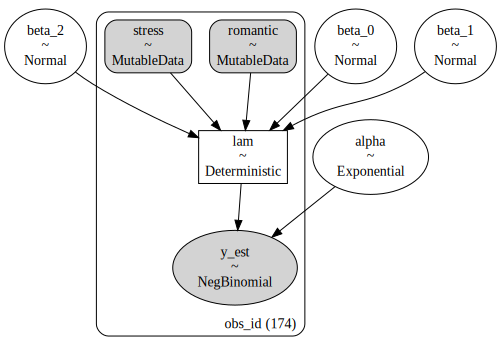

In [137]:
pm.model_to_graphviz(nb_model)

#### MCMC采样

In [138]:
#===========================
#     注意！！！以下代码可能需要运行1-2分钟左右
#===========================
with nb_model:
    nb_model_trace = pm.sample(draws=5000,            # 使用mcmc方法进行采样，draws为采样次数
                      tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                      chains=4,                     # 链数
                      discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                      random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 142 seconds.


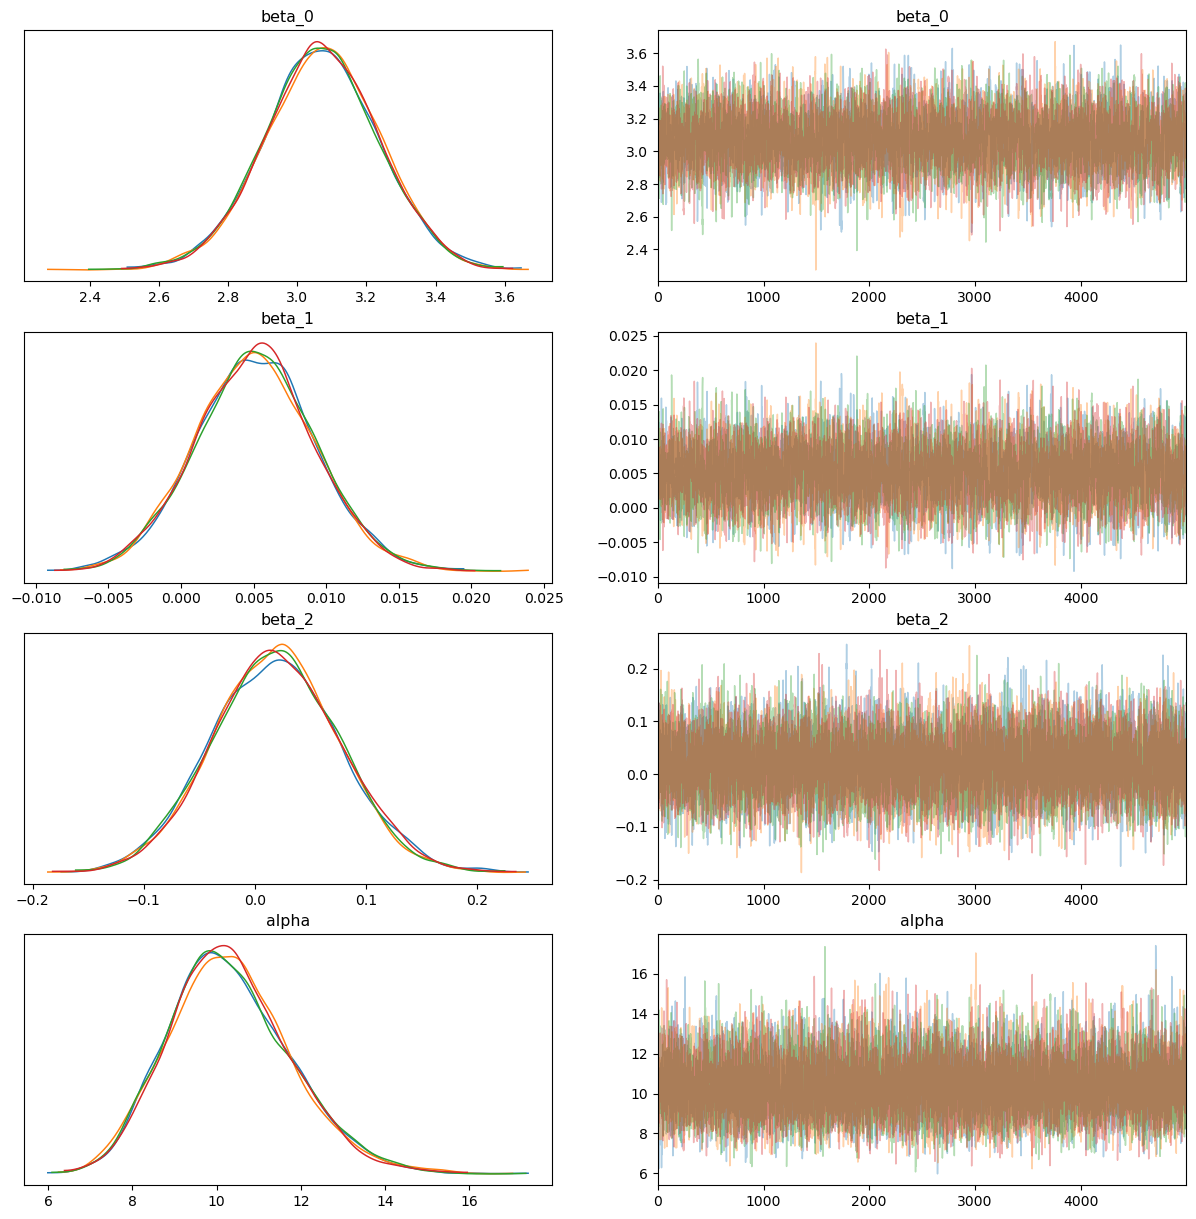

In [139]:
az.plot_trace(nb_model_trace, var_names=["beta_0","beta_1","beta_2","alpha"],
              figsize=(15,15),
              compact=False)
plt.show()

#### 后验预测分布

In [140]:
with nb_model:
    nb_model_ppc = pm.sample_posterior_predictive(nb_model_trace, random_seed=84735) 

Sampling: [y_est]


<Axes: xlabel='y_est / y_est'>

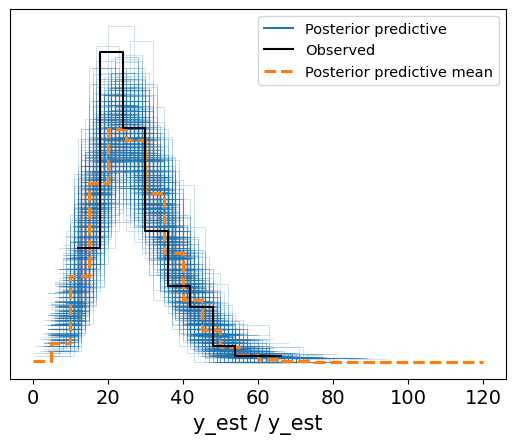

In [141]:
az.plot_ppc(nb_model_ppc, num_pp_samples=500)

#### 评估后验预测

In [142]:
# 输出结果
nb_model_MAE = MAE(nb_model_ppc)
print(f"负二项回归模型MAE: {nb_model_MAE:.2f}")

# 输出结果
nb_model_outliers = counter_outlier(nb_model_ppc)
print(f"负二项回归模型超出95%hdi: {nb_model_outliers:.2f}")

负二项回归模型MAE: 6.48


负二项回归模型超出95%hdi: 9.00


### 模型比较

In [143]:
with nb_model:
    pm.compute_log_likelihood(nb_model_trace)

In [144]:
comparison_list = {
    "model1(normal)":normal_model_trace,
    "model2(poisson)":poisson_model_trace,
    "model3(negative binomial)":nb_model_trace,
}
az.compare(comparison_list)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model3(negative binomial),0,-628.665376,3.224260,0.000000,0.874087,9.262558,0.000000,False,log
model1(normal),1,-637.875179,4.337762,9.209803,0.000000,11.968966,4.485639,False,log
model2(poisson),2,-709.111664,9.236234,80.446288,0.125913,30.371556,21.679144,False,log


## GLM